# Intra-Day Statistics

In [43]:
import os
import copy
import random
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 
import statsmodels.api as sm
import matplotlib.pyplot as plt

from matplotlib.transforms import Affine2D
from pandas.plotting import autocorrelation_plot
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering



## 1. Exploratory Data Analysis

### 1.1 Load and Arrange data

In [44]:
# Load dataset
df = pd.read_csv('TradesCleaned.csv')

In [45]:
# Create figures file
directory = os.getcwd()
if not os.path.exists(os.path.join(directory,'figures')):
    os.makedirs(os.path.join(directory,'figures'))

In [46]:
df.dtypes

valueDate     object
family        object
spread       float64
size         float64
dtype: object

In [47]:
df['valueDate'] = pd.to_datetime(df['valueDate'])
df.set_index('valueDate', inplace=True)

In [48]:
df.dtypes

family     object
spread    float64
size      float64
dtype: object

## 2. Correlation Returns

Using the paper written by Hayashi, we define the correlation coefficient for the intraday returns as the following.
$$\rho = \frac{\sum_{i,j} \Delta P^{1}(I^{i})\Delta P^{2}(I^{j})1_{\{I^{i}\cap J^{j} \neq \emptyset\}}}{\{ \sum_{i} \Delta P^{1}(I^i)^2\}^{\frac{1}{2}}\{ \sum_{j} \Delta P^{1}(J^j)^2\}^{\frac{1}{2}} 1_{\{I^{i}\cap J^{j} \neq \emptyset\}}}$$
Where:
- $I_{i}$: represents the time interval for the price i to the previous price, for product 1.
- $J_{j}$: represents the time interval for the price j to the previous price, for product 2.
- $\{ \sum_{i} \Delta P^{1}(I^i)^2\}^{\frac{1}{2}}$: is the daily standard deviation of the delta returns for product 1 over intersect interval.
- $\{ \sum_{j} \Delta P^{1}(J^j)^2\}^{\frac{1}{2}}$: is the daily standard deviation of the delta returns for product 2 over intersect interval.
- $\Delta P^{1}(I^{i})\Delta P^{2}(I^{j})1_{\{I^{i}\cap J^{j} \neq \emptyset\}}$: Is the sum of returns for product 1 and 2 whose time interval intersect, where $\Delta P^{1}(I^{i})$ and  $\Delta P^{2}(J^{j})$, have been normalise as follows:
    - $\Delta P^{1}(I^{i}) = \Delta P^{1}(I^{i})_{orig} - \frac{\sum_{k}\Delta P^{1}(I^{k})_{orig}}{\sum_{k} \Delta t_{1,k}}* \Delta t_{1,i}$
    - $\Delta P^{2}(J^{j}) = \Delta P^{1}(J^{j})_{orig} - \frac{\sum_{k}\Delta P^{2}(J^{k})_{orig}}{\sum_{k} \Delta t_{2,k}}* \Delta t_{2,j}$
    - We take the orginal R, then we take way the sum of the returns for that index overall the whole day and we divide by the whole time from start to close, multiplied by the time difference to the previous trade. Like this we remove any noise specific to that index on a particular date.

In order to calculate that we procede in the following fashion:
- Take the columns of the log spreads.
- Group by day and compute the difference for each day to otain the intra day returns.
- unstack so as to have the date as an index and the returns for each family as seperate columns.
- Select two indices to compute the correlation
- drop rows where both columns have NaNs
- Group by day and bfill missing values, then fill the rest of the missing values by 0.
- Compute the intraday standard deviation for each column.
- Compute correlation coefficient.

In [49]:
# Create log column for the spreads
df['log_spread'] = np.log(df['spread'])

In [50]:
# Create copy of original data set
df_temp = df.copy()
df_temp = df_temp.reset_index()
df_temp['valueDate_copy'] = df_temp['valueDate']
df_temp.set_index(['family','valueDate'], inplace=True)
print(df_temp.shape)
df_temp

(1177032, 4)


spread        size  log_spread  \
family valueDate                                               
CDXEM  2013-01-31 15:35:46  229.9410   5000000.0    5.437823   
       2013-01-31 16:15:27  232.5927   7000000.0    5.449289   
       2013-01-31 17:07:08  229.9410  10000000.0    5.437823   
       2013-01-31 17:15:32  233.0010   4000000.0    5.451043   
       2013-01-31 19:11:59  232.5927  20000000.0    5.449289   
...                              ...         ...         ...   
ITXEX  2020-04-08 10:33:07  545.5000   5000000.0    6.301703   
       2020-04-08 10:33:39  547.5000  15000000.0    6.305362   
       2020-04-08 10:41:48  549.5000  10000000.0    6.309009   
       2020-04-08 10:58:29  545.5900   5000000.0    6.301868   
       2020-04-08 11:23:17  546.2500   3000000.0    6.303077   

                                valueDate_copy  
family valueDate                                
CDXEM  2013-01-31 15:35:46 2013-01-31 15:35:46  
       2013-01-31 16:15:27 2013-01-31 16:15:27  
       2013-01-31 17:07:08 2013-01-31 17:07:08  
       2013-01-31 17:15:32 2013-01-31 17:15:32  
       2013-01-31 19:11:59 2013-01-31 19:11:59  
...                                        ...  
ITXEX  2020-04-08 10:33:07 2020-04-08 10:33:07  
       2020-04-08 10:33:39 2020-04-08 10:33:39  
       2020-04-08 10:41:48 2020-04-08 10:41:48  
       2020-04-08 10:58:29 2020-04-08 10:58:29  
       2020-04-08 11:23:17 2020-04-08 11:23:17  

[1177032 rows x 4 columns]

In [51]:
# Compute the returns for the log spreads for each day
df_temp = pd.DataFrame(df_temp.groupby([pd.Grouper(level='family'), pd.Grouper(freq='D', level='valueDate')])[['log_spread','valueDate_copy']].diff())
# Set to zero the difference to the previous trade for the first trade of the day
df_temp['log_spread'] = df_temp['log_spread'].fillna(0)
# Set to time delta 0 the first time difference of the day
df_temp['valueDate_copy'] = df_temp['valueDate_copy'].fillna(np.timedelta64(0, 'D'))
# Convert tiem delta to seconds
df_temp['valueDate_copy']  = df_temp['valueDate_copy'].apply(lambda x: x.seconds)

In [52]:
df_temp

log_spread  valueDate_copy
family valueDate                                      
CDXEM  2013-01-31 15:35:46    0.000000               0
       2013-01-31 16:15:27    0.011466            2381
       2013-01-31 17:07:08   -0.011466            3101
       2013-01-31 17:15:32    0.013220             504
       2013-01-31 19:11:59   -0.001754            6987
...                                ...             ...
ITXEX  2020-04-08 10:33:07   -0.010758            1088
       2020-04-08 10:33:39    0.003660              32
       2020-04-08 10:41:48    0.003646             489
       2020-04-08 10:58:29   -0.007141            1001
       2020-04-08 11:23:17    0.001209            1488

[1177032 rows x 2 columns]

In [53]:
# Create a dataframe with the sum of Deltas Returns and time for each day
df_totals = df_temp.groupby([pd.Grouper(level='family'),pd.Grouper(freq='D',level='valueDate')]).transform('sum')
df_totals.columns = ['total_log_spread','total_valueDate_copy']

In [54]:
# Merge daily totals with orginal dataset 
df_temp = df_temp.merge(df_totals, how = 'left', left_index = True, right_index = True)

In [55]:
# Normalise intra day Returns
df_temp['log_spread_normalised'] = df_temp['log_spread'] - df_temp['total_log_spread']*df_temp['valueDate_copy']/df_temp['total_valueDate_copy']

In [56]:
df_temp

log_spread  valueDate_copy  total_log_spread  \
family valueDate                                                           
CDXEM  2013-01-31 15:35:46    0.000000               0         -0.008897   
       2013-01-31 16:15:27    0.011466            2381         -0.008897   
       2013-01-31 17:07:08   -0.011466            3101         -0.008897   
       2013-01-31 17:15:32    0.013220             504         -0.008897   
       2013-01-31 19:11:59   -0.001754            6987         -0.008897   
...                                ...             ...               ...   
ITXEX  2020-04-08 10:33:07   -0.010758            1088         -0.029314   
       2020-04-08 10:33:39    0.003660              32         -0.029314   
       2020-04-08 10:41:48    0.003646             489         -0.029314   
       2020-04-08 10:58:29   -0.007141            1001         -0.029314   
       2020-04-08 11:23:17    0.001209            1488         -0.029314   

                            total_valueDate_copy  log_spread_normalised  
family valueDate                                                         
CDXEM  2013-01-31 15:35:46                 20211               0.000000  
       2013-01-31 16:15:27                 20211               0.012514  
       2013-01-31 17:07:08                 20211              -0.010101  
       2013-01-31 17:15:32                 20211               0.013442  
       2013-01-31 19:11:59                 20211               0.001322  
...                                          ...                    ...  
ITXEX  2020-04-08 10:33:07                 18258              -0.009011  
       2020-04-08 10:33:39                 18258               0.003711  
       2020-04-08 10:41:48                 18258               0.004431  
       2020-04-08 10:58:29                 18258              -0.005534  
       2020-04-08 11:23:17                 18258               0.003598  

[1177032 rows x 5 columns]

In [57]:
# keep only log_spread_normalised
df_temp.drop(['log_spread','valueDate_copy','total_log_spread','total_valueDate_copy'], axis=1, inplace=True)

In [58]:
# create returns column per family of index type
df_returns_intraday = df_temp.unstack(level=0)
df_returns_intraday.columns = df_returns_intraday.columns.get_level_values(level=1)

In [87]:
# Use df_returns_intraday which is the returns of the log prices per day.
# create list of families of credit index swaps.
columns = list(df_returns_intraday.columns)
# Iterate over each family
for index, column in enumerate(columns):
    # Compute correlation with different families excluding those already obtained due to symmetry.
    target_col = columns[index+1:]
    # Compute for each pairs the correlation coefficient
    for index_j, j in enumerate(target_col):
        # Remove all rows where the two indices have no trades in common
        df_corr = df_returns_intraday[[column,j]].dropna(how = 'all')
        # Backfill per day then complete with 0 for remaining nan
        df_corr = df_corr.groupby([pd.Grouper(freq='12H')]).fillna(method='bfill').fillna(0)
        # Multiply Delta log(P_X) * Delta log(P_Y)
        df_corr[column + '_' + j] = df_corr[column]*df_corr[j]
        # Compute standart deviation for X and Y per day
        # Select Delta P(x) and P(y) where intervals intersect 
        index1 = list(df_corr.loc[df_corr[column + '_' + j]!=0,:].index)
        df_stdv = df_returns_intraday.loc[index1,[column,j]].groupby([pd.Grouper(freq='12H')]).agg({column:lambda x: np.sqrt(np.sum(np.square(x))), j:lambda x: np.sqrt(np.sum(np.square(x)))})
        df_common_transactions = df_returns_intraday.loc[index1,[column,j]].groupby([pd.Grouper(freq='12H')]).agg({column:'count',j:'count'})
        df_common_transactions.columns = [column+'_common_transactions', j+'_common_transactions']
        # Create output data frame
        if (index == 0) & (index_j == 0):
            # sum the Delta log(P_X) * Delta log(P_Y) column
            df_intraday_correlation = df_corr.groupby([pd.Grouper(freq='12H')]).agg({column + '_' + j:'sum'})
            # merge per date the standard deviation
            df_intraday_correlation = df_intraday_correlation.merge(df_stdv, how='left', left_index=True, right_index=True)
            # Compute the Correlation coefficient
            df_intraday_correlation[column + '_' + j] = df_intraday_correlation[column + '_' + j]/(df_intraday_correlation[column]*df_intraday_correlation[j])
            # drop the standard deviation columns
            df_intraday_correlation.drop([column,j], axis=1, inplace=True)
            # Create column of common number of transactions
            df_intraday_correlation = df_intraday_correlation.merge(df_common_transactions, how='left', left_index=True, right_index=True)
        else:
            # sum the Delta log(P_X) * Delta log(P_Y) column
            df_intraday_correlation[column + '_' + j] = df_corr.groupby([pd.Grouper(freq='12H')]).agg({column + '_' + j:'sum'})
            # merge per date the standard deviation
            df_intraday_correlation = df_intraday_correlation.merge(df_stdv, how='left', left_index=True, right_index=True)
            # Compute the Correlation coefficient
            df_intraday_correlation[column + '_' + j] = df_intraday_correlation[column + '_' + j]/(df_intraday_correlation[column]*df_intraday_correlation[j])
            # drop the standard deviation columns
            df_intraday_correlation.drop([column,j], axis=1, inplace=True)
            # Create column of common number of transactions
            df_intraday_correlation = df_intraday_correlation.merge(df_common_transactions, how='left', left_index=True, right_index=True)
            

In [79]:
df_intraday_correlation

,CDXEM_CDXHY,CDXEM_common_transactions_x,CDXHY_common_transactions_x,CDXEM_CDXIG,CDXEM_common_transactions_y,CDXIG_common_transactions_x,CDXEM_ITXEB,CDXEM_common_transactions_x,ITXEB_common_transactions_x,CDXEM_ITXES,...,ITXEX_common_transactions_x,ITXEB_ITXES,ITXEB_common_transactions_y,ITXES_common_transactions_y,ITXEB_ITXEX,ITXEB_common_transactions,ITXEX_common_transactions_y,ITXES_ITXEX,ITXES_common_transactions,ITXEX_common_transactions
valueDate,,,,,,,,,,,,,,,,,,,,,
2013-01-02 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-08 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0
2020-04-08 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0
2020-04-08 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.542251,11.0,5.0,0.662211,12.0,11.0,0.544966,5.0,10.0


In [ ]:
dict_correlation = dict()

In [69]:
i = 0 
for index, column in enumerate(columns):
    target_col = columns[index+1:]
    for index_j, column_j in enumerate(target_col):
        dict_correlation[column+'_'+column_j] = {'1H':{'median':np.median(df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j])}}
        dict_correlation[column+'_'+column_j]['1H'].update({'Lquantile':df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j].quantile(0.025)})
        dict_correlation[column+'_'+column_j]['1H'].update({'Uquantile':df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j].quantile(0.975)})

In [75]:
i = 0 
for index, column in enumerate(columns):
    target_col = columns[index+1:]
    for index_j, column_j in enumerate(target_col):
        dict_correlation[column+'_'+column_j].update({'1H':{'median':np.median(df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j])}})
        dict_correlation[column+'_'+column_j]['1H'].update({'Lquantile':df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j].quantile(0.25)})
        dict_correlation[column+'_'+column_j]['1H'].update({'Uquantile':df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j].quantile(0.75)})

In [78]:
i = 0 
for index, column in enumerate(columns):
    target_col = columns[iandex+1:]
    for index_j, column_j in enumerate(target_col):
        dict_correlation[column+'_'+column_j].update({'2H':{'median':np.median(df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j])}})
        dict_correlation[column+'_'+column_j]['2H'].update({'Lquantile':df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j].quantile(0.25)})
        dict_correlation[column+'_'+column_j]['2H'].update({'Uquantile':df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j].quantile(0.75)})

In [82]:
i = 0 
for index, column in enumerate(columns):
    target_col = columns[index+1:]
    for index_j, column_j in enumerate(target_col):
        dict_correlation[column+'_'+column_j].update({'4H':{'median':np.median(df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j])}})
        dict_correlation[column+'_'+column_j]['4H'].update({'Lquantile':df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j].quantile(0.25)})
        dict_correlation[column+'_'+column_j]['4H'].update({'Uquantile':df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j].quantile(0.75)})

In [86]:
i = 0 
for index, column in enumerate(columns):
    target_col = columns[index+1:]
    for index_j, column_j in enumerate(target_col):
        dict_correlation[column+'_'+column_j].update({'8H':{'median':np.median(df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j])}})
        dict_correlation[column+'_'+column_j]['8H'].update({'Lquantile':df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j].quantile(0.25)})
        dict_correlation[column+'_'+column_j]['8H'].update({'Uquantile':df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j].quantile(0.75)})

In [89]:
i = 0 
for index, column in enumerate(columns):
    target_col = columns[index+1:]
    for index_j, column_j in enumerate(target_col):
        dict_correlation[column+'_'+column_j].update({'12H':{'median':np.median(df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j])}})
        dict_correlation[column+'_'+column_j]['12H'].update({'Lquantile':df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j].quantile(0.25)})
        dict_correlation[column+'_'+column_j]['12H'].update({'Uquantile':df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j].quantile(0.75)})

In [92]:
dict_correlation.pop('1D')

{'median': 0.251475753671515,
 'Lquantile': -0.15656732007448768,
 'Uquantile': 0.7518911828273142}

In [100]:
keys = list(dict_correlation['ITXES_ITXEX'].keys())

In [104]:
keys.pop(0)

'1D'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


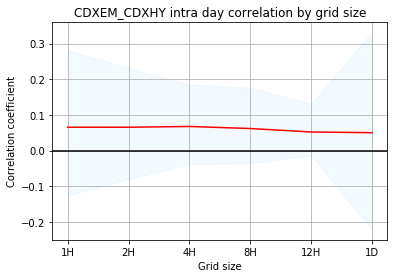

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


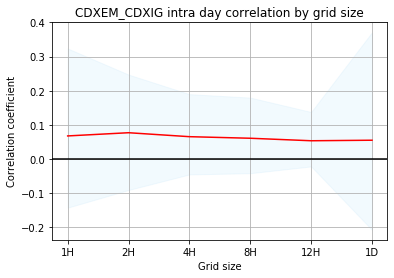

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


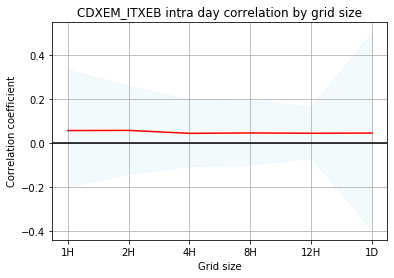

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


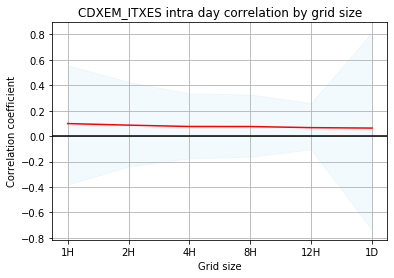

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


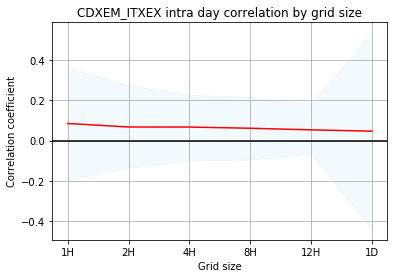

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


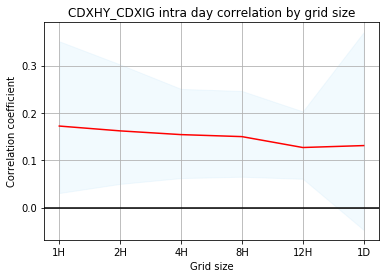

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


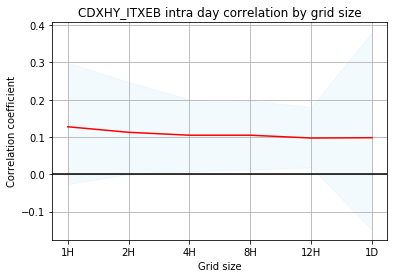

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


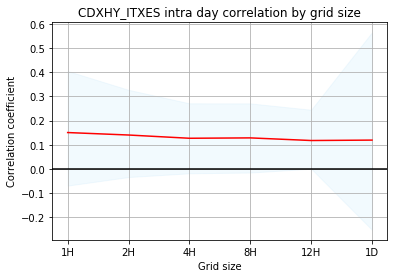

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


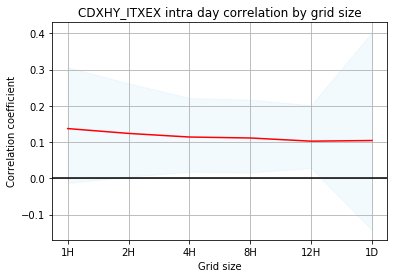

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


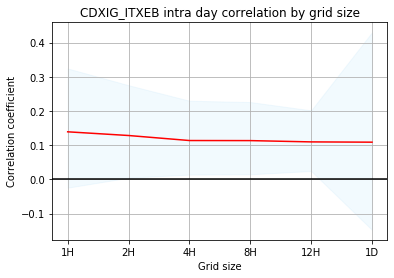

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


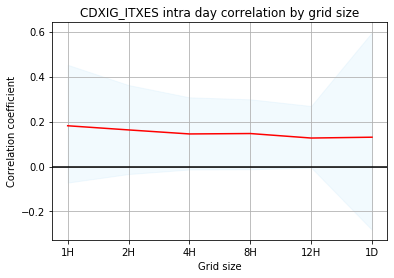

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


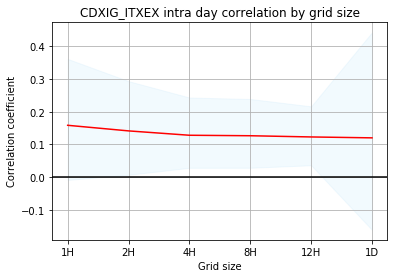

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


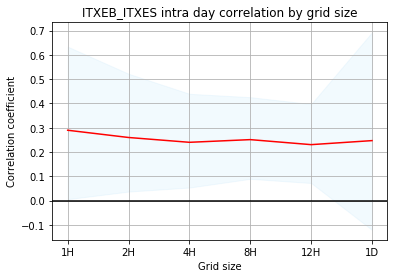

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


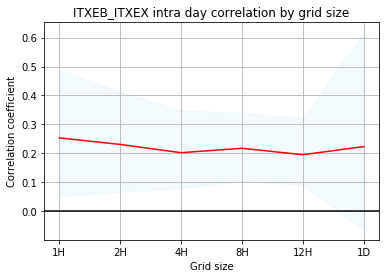

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


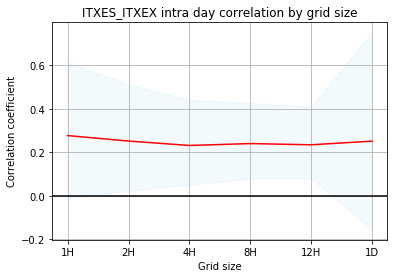

In [116]:
for i in dict_correlation:
    lower = []
    upper = []
    median = []
    for j in keys:
        lower.append(dict_correlation[i][j]['Lquantile'])
        upper.append(dict_correlation[i][j]['Uquantile'])
        median.append(dict_correlation[i][j]['median'])
    plt.plot(keys, median, color='r')
    plt.fill_between(keys, np.array(lower), np.array(upper), color= [(135/255,206/255,250/255)], alpha=.1)
    plt.axhline(color='k')
    plt.xlabel('Grid size')
    plt.ylabel('Correlation coefficient')
    plt.title(i + ' intra day correlation by grid size')
    plt.grid()  
    plt.savefig('figures/' + i + '_correlation_grid_size.eps')
    plt.show()

In [105]:
keys.append('1D')

In [18]:
# Create columns per family index type of daily number of trades
df_intraday_correlation = df_intraday_correlation.merge(df_returns_intraday.groupby([pd.Grouper(freq='D')]).count(),how='left',left_index=True, right_index=True)

In [19]:
# Compute ratio of number of trades per correlation
for index, column in enumerate(columns):
    # Compute correlation with different families excluding those already obtained due to symmetry.
    target_col = columns[index+1:]
    # Compute for each pairs the correlation coefficient
    for index_j, j in enumerate(target_col):
        df_intraday_correlation['ratio_' + column+'_'+j] = df_intraday_correlation[column]/df_intraday_correlation[j]
        

In [20]:
temp =df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna().mean()

In [21]:
temp = pd.DataFrame(temp)

In [22]:
temp

,0
CDXEM_CDXHY,0.056661
CDXEM_common_transactions_x,36.618960
CDXHY_common_transactions_x,186.475841
CDXEM_CDXIG,0.059795
CDXEM_common_transactions_y,36.613456
...,...
ratio_CDXIG_ITXES,6.519519
ratio_CDXIG_ITXEX,1.787367
ratio_ITXEB_ITXES,4.031609
ratio_ITXEB_ITXEX,1.136771


In [23]:
temp.loc[['CDXEM_CDXHY','CDXEM_CDXIG','CDXEM_ITXEB','CDXEM_ITXES','CDXEM_ITXEX'],:]

,0
CDXEM_CDXHY,0.056661
CDXEM_CDXIG,0.059795
CDXEM_ITXEB,0.049736
CDXEM_ITXES,0.064131
CDXEM_ITXEX,0.035866


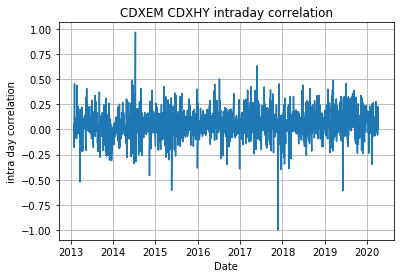

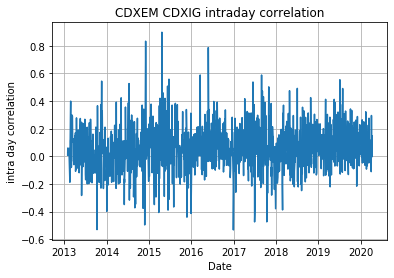

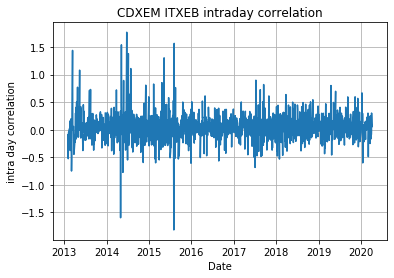

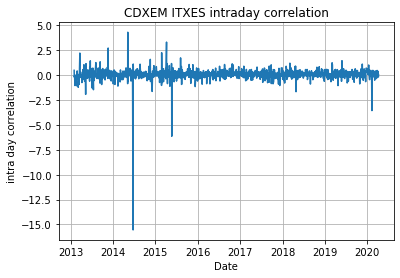

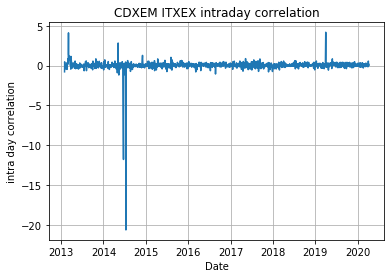

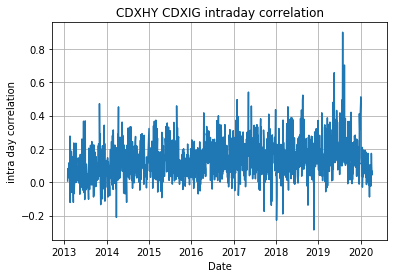

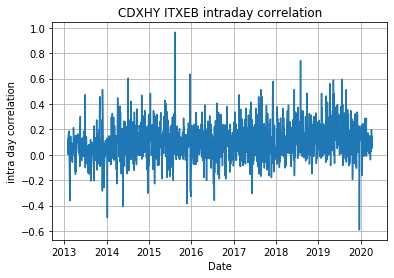

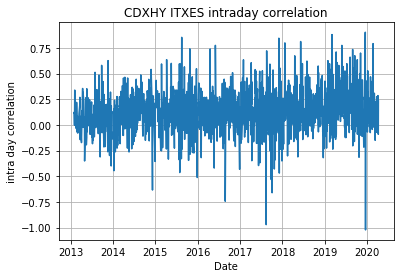

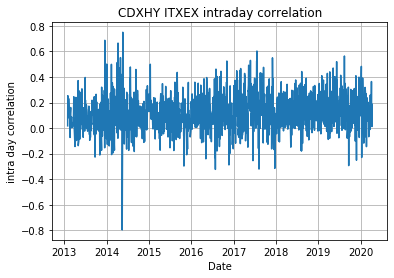

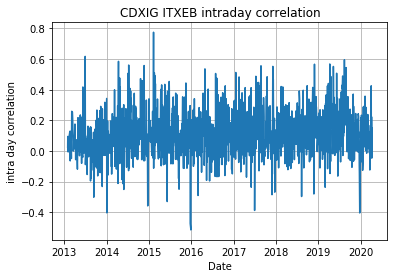

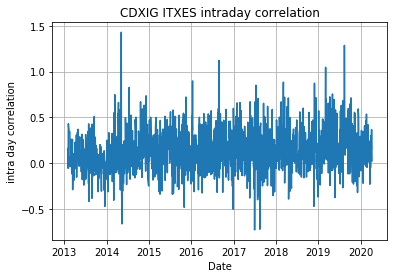

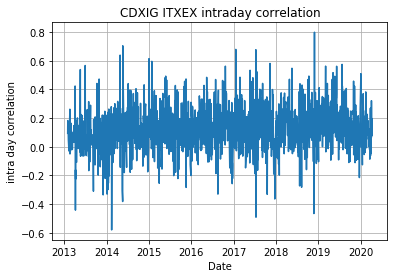

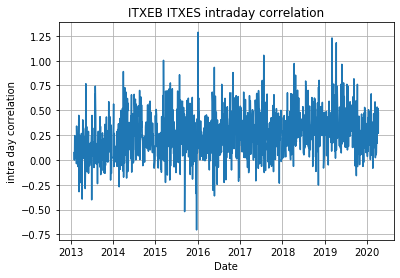

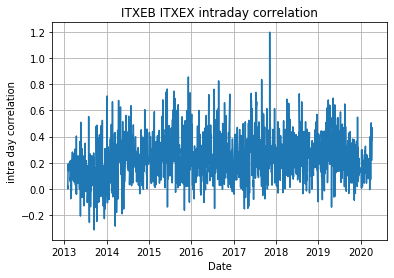

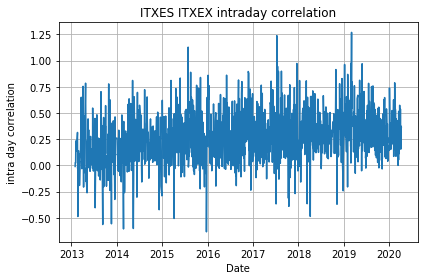

In [24]:
# Plot intra day returns correlation
i = 0 
for index, column in enumerate(columns):
    target_col = columns[index+1:]
    for index_j, column_j in enumerate(target_col):
        fig, ax = plt.subplots()
        plt.plot(df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().dropna()[column+'_'+column_j])
        plt.grid()
        plt.xlabel(xlabel="Date")
        plt.ylabel( ylabel="intra day correlation")
        plt.title(column+ ' ' + column_j +' intraday correlation')
        plt.savefig('figures/'+ column + '_' + column_j + '.eps')
        
plt.tight_layout()

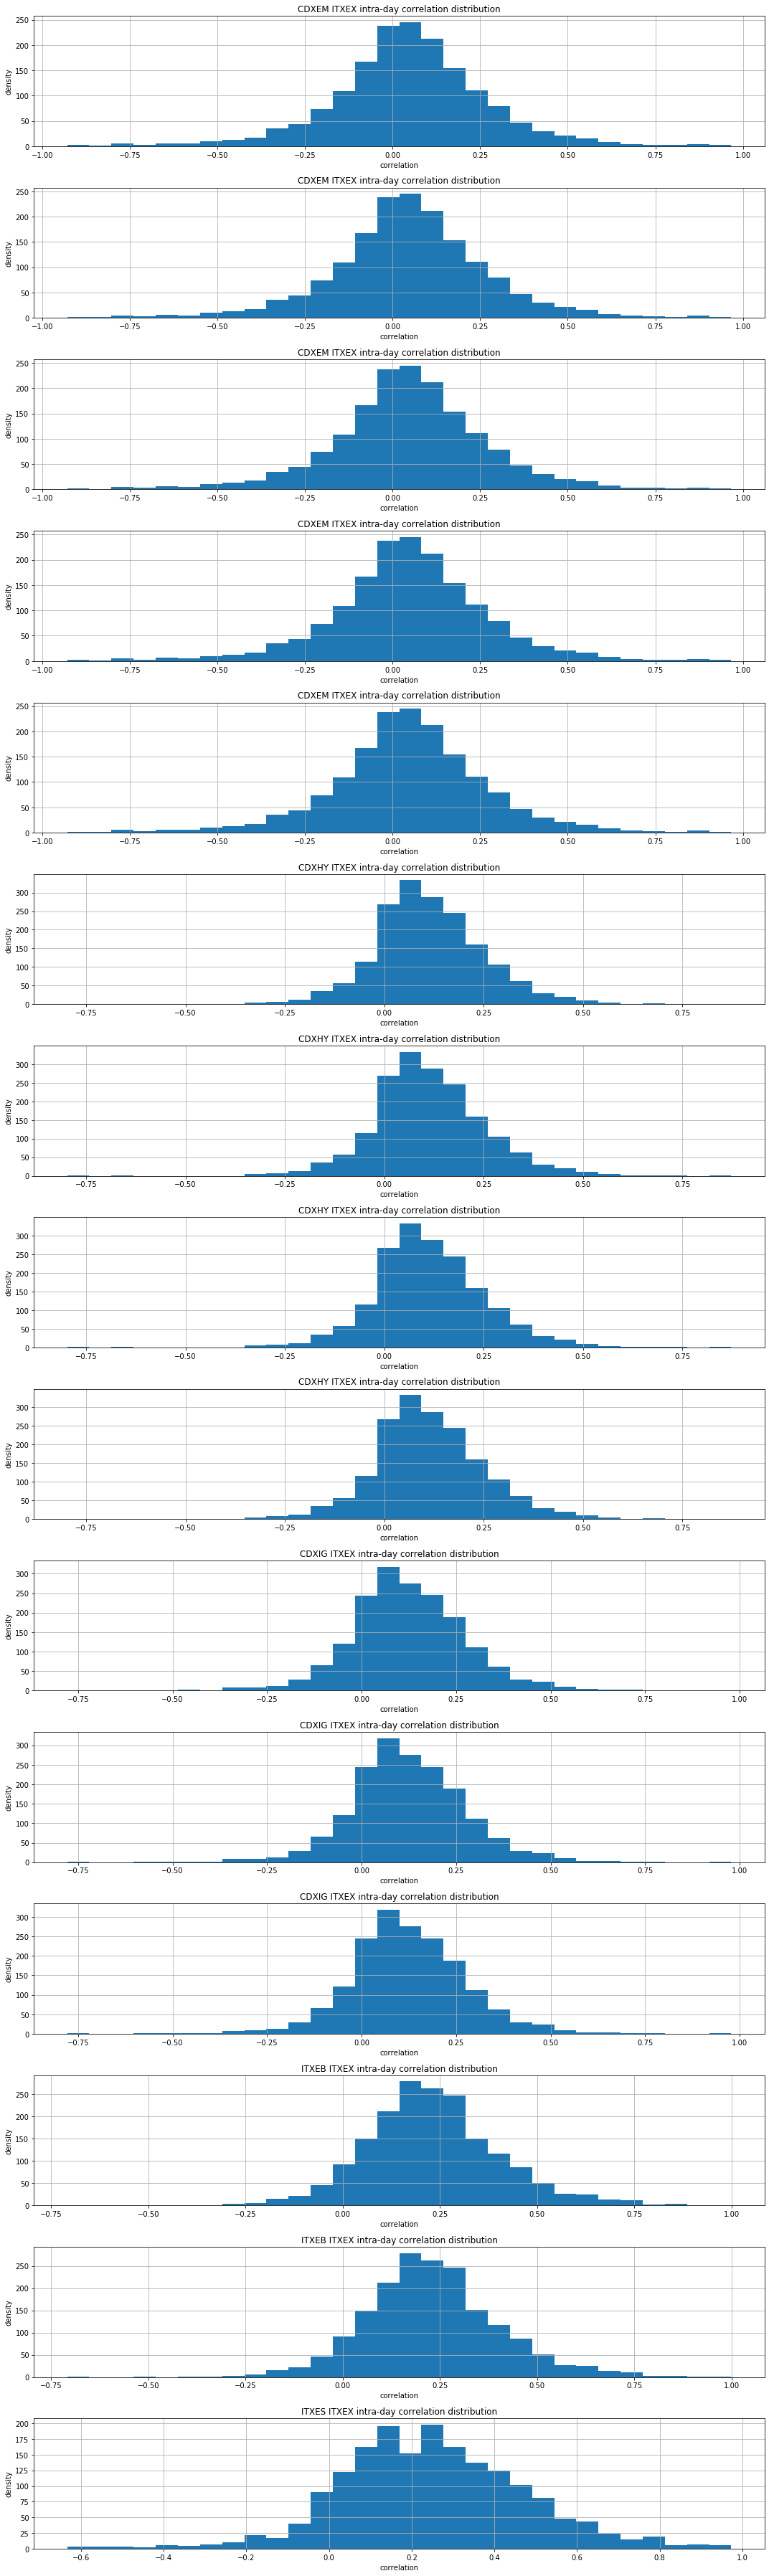

In [25]:
# Plot intraday correlation distribution per index type
columns = ['CDXEM', 'CDXHY', 'CDXIG', 'ITXEB', 'ITXES', 'ITXEX']
fig, ax = plt.subplots(15, figsize=(15,50))
i = 0
for index, column in enumerate(columns):
    target_col = columns[index+1:]
    for index_j, columns_j in enumerate(target_col):
        # Select only values smaller than one
        ax[i].hist(df_intraday_correlation.loc[np.abs(df_intraday_correlation[column+'_'+j])<=1,column+'_'+j].dropna(), bins=30)
        ax[i].grid()
        ax[i].set(ylabel= 'density', xlabel='correlation', title= column + ' ' + column_j + ' intra-day correlation distribution')
        i+=1
plt.tight_layout()

In [26]:
df_intraday_correlation

,CDXEM_CDXHY,CDXEM_common_transactions_x,CDXHY_common_transactions_x,CDXEM_CDXIG,CDXEM_common_transactions_y,CDXIG_common_transactions_x,CDXEM_ITXEB,CDXEM_common_transactions_x,ITXEB_common_transactions_x,CDXEM_ITXES,...,ratio_CDXHY_CDXIG,ratio_CDXHY_ITXEB,ratio_CDXHY_ITXES,ratio_CDXHY_ITXEX,ratio_CDXIG_ITXEB,ratio_CDXIG_ITXES,ratio_CDXIG_ITXEX,ratio_ITXEB_ITXES,ratio_ITXEB_ITXEX,ratio_ITXES_ITXEX
valueDate,,,,,,,,,,,,,,,,,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.441176,inf,inf,inf,inf,inf,inf,NaN,NaN,NaN
2013-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.633333,1.461538,inf,inf,2.307692,inf,inf,inf,inf,NaN
2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.750000,1.810345,inf,6.562500,2.413793,inf,8.750000,inf,3.625000,0.000000
2013-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-04,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-05,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-06,0.003856,28.0,199.0,-0.003727,29.0,218.0,0.052000,23.0,40.0,-0.173443,...,0.914163,2.108911,11.833333,2.597561,2.306931,12.944444,2.841463,5.611111,1.231707,0.219512


In [27]:
# Save days where the absolute correlation is higher than 1.
intra_day_colleration_outliers = dict()
intra_day_colleration_outliers_shape = dict()
for index, column in enumerate(columns):
    target_col = columns[index+1:]
    for index_j, column_j in enumerate(target_col):
        df_outlier = pd.DataFrame(df_intraday_correlation.replace({np.inf:np.nan,-np.inf:np.nan}).dropna().loc[np.abs(df_intraday_correlation[column+'_'+column_j])>1,:])
        intra_day_colleration_outliers[column+'_'+column_j] = df_outlier[[column+'_'+column_j, 'ratio_' +column+'_'+column_j,column,column_j,column+'_common_transactions',  j+'_common_transactions']]
        intra_day_colleration_outliers_shape[column+'_'+column_j] = intra_day_colleration_outliers[column+'_'+column_j].shape

In [28]:
intra_day_colleration_outliers

{'CDXEM_CDXHY': Empty DataFrame
 Columns: [CDXEM_CDXHY, ratio_CDXEM_CDXHY, CDXEM, CDXHY, CDXEM_common_transactions, ITXEX_common_transactions]
 Index: [],
 'CDXEM_CDXIG': Empty DataFrame
 Columns: [CDXEM_CDXIG, ratio_CDXEM_CDXIG, CDXEM, CDXIG, CDXEM_common_transactions, ITXEX_common_transactions]
 Index: [],
 'CDXEM_ITXEB':             CDXEM_ITXEB  ratio_CDXEM_ITXEB  CDXEM  ITXEB  \
 valueDate                                                  
 2013-03-13     1.438086           0.109589      8     73   
 2013-05-13     1.079669           0.055556      5     90   
 2014-05-01    -1.597885           0.250000      7     28   
 2014-05-08     1.539100           0.142857     12     84   
 2014-06-23     1.767639           0.076087      7     92   
 2014-07-07     1.379730           0.134146     11     82   
 2014-07-28     1.108501           0.265625     17     64   
 2015-05-11     1.303021           0.406780     24     59   
 2015-08-03    -1.818645           0.348837     15     43   
 201

In [29]:
intra_day_colleration_outliers_shape

{'CDXEM_CDXHY': (0, 6),
 'CDXEM_CDXIG': (0, 6),
 'CDXEM_ITXEB': (10, 6),
 'CDXEM_ITXES': (45, 6),
 'CDXEM_ITXEX': (13, 6),
 'CDXHY_CDXIG': (0, 6),
 'CDXHY_ITXEB': (0, 6),
 'CDXHY_ITXES': (1, 6),
 'CDXHY_ITXEX': (0, 6),
 'CDXIG_ITXEB': (0, 6),
 'CDXIG_ITXES': (4, 6),
 'CDXIG_ITXEX': (0, 6),
 'ITXEB_ITXES': (5, 6),
 'ITXEB_ITXEX': (1, 6),
 'ITXES_ITXEX': (3, 6)}

As can be seen from the results there exist a few outlier. They occur mainly for the CDXEM index versus ITX indices. They occur when the number of transactions occuring in the same time interval for those two families is very small. typically there is one trade occuring with the time of a lot of trades for the other indices. 

## 3. Returns Variance and Standard Deviation

Random walk realised variance for day t:
- $ Var(\Delta P_{t}) = \frac{\sum_{i}^{N} ( \Delta P_{i,t} - \frac{\sum_{j}^{N} \Delta P_{j,t} \Delta t_{j,t})}{\sum_{j}^{N} \Delta t_{j,t}})^2}{\sum_i^{j} \Delta t_{i,t}} $   
- N: the number of returns in a day.
- $\sum_j \Delta t_{j}$: The sum of the time intervals between trades over single day
- $\Delta P_{i,t} - \frac{\sum_{j}^{N} \Delta P_{j,t} \Delta t_{j,t})}{\sum_{j}^{N} \Delta t_{j,t}}$: Normalise the returns by the time increment weighted mean

In [30]:
df.reset_index(inplace=True)

In [31]:
# Create copy of original dataset
df_temp = df.copy()
df_temp['valueDate_copy'] = df_temp['valueDate']
df_temp = df_temp.reset_index().set_index(['family','valueDate'])
# find intra day returns and time differences.
df_temp = pd.DataFrame(df_temp.groupby([pd.Grouper(level='family'), pd.Grouper(freq='D', level='valueDate')])[['log_spread','valueDate_copy']].diff())
df_temp.columns = ['variation_log_spread', 'variation_dt']
# Drop first transaction row
df_temp.dropna(inplace=True)

In [32]:
df_temp['variation_dt'] = df_temp['variation_dt'].apply(lambda x: x.seconds)

In [33]:
# Find sum of delta t for each day
df_daily_mean = pd.DataFrame(df_temp.groupby([pd.Grouper(level='family'), pd.Grouper(freq='D', level='valueDate')])[['variation_dt','variation_log_spread']].transform('sum'))
df_daily_mean.columns = ['total_variation_dt','sum_variation_returns']

In [34]:
# Merge
df_temp = df_temp.merge(df_daily_mean,how='left', left_index=True, right_index=True)

In [35]:
# normalise daily returns 
df_temp['normalised_variation_log_spread'] = df_temp['variation_log_spread'] - df_temp['sum_variation_returns']*df_temp['variation_dt']/df_temp['total_variation_dt']
# Square returns
df_temp['normalised_variation_log_spread'] = df_temp['normalised_variation_log_spread'].apply(lambda x: x**2)
df_temp['variation_log_spread'] = df_temp['variation_log_spread'].apply(lambda x: x**2)
# sum and count daily square returns
df_temp = pd.DataFrame(df_temp.groupby([pd.Grouper(level='family'), pd.Grouper(freq='D', level='valueDate')]).agg({'normalised_variation_log_spread':['sum','count'],'variation_log_spread':'sum','variation_dt':'sum'}))
df_temp.columns = ['normalised_variation_log_spread','count','variation_log_spread','DELTA_T']
# divide sum of daily returns by number of transactions to get daily variance of returns
df_temp['realised_variance'] = df_temp['variation_log_spread']
df_temp['variance'] = df_temp['normalised_variation_log_spread']/df_temp['count']
# Take square root of variance to get the standard deviation
df_temp['std_dv'] = df_temp['variance'].apply(lambda x: np.sqrt(x))
df_temp['realised_volatility'] = df_temp['realised_variance'].apply(lambda x: np.sqrt(x))
# Variance Random walk per day
df_temp['random_walk_variance_day'] = df_temp['normalised_variation_log_spread']/(df_temp['DELTA_T']/(3600*24))
df_temp['random_walk_volatility_day'] = df_temp['random_walk_variance_day'].apply(lambda x: np.sqrt(x))

In [36]:
df_temp

normalised_variation_log_spread  count  \
family valueDate                                            
CDXEM  2013-01-31                         0.000644      6   
       2013-02-01                         0.001814      7   
       2013-02-04                         0.000488      6   
       2013-02-05                         0.000000      1   
       2013-02-06                         0.000532      4   
...                                            ...    ...   
ITXEX  2020-04-02                         0.003584     97   
       2020-04-03                         0.007011     99   
       2020-04-06                         0.001856     81   
       2020-04-07                         0.003008     76   
       2020-04-08                         0.001088     33   

                   variation_log_spread  DELTA_T  realised_variance  variance  \
family valueDate                                                                
CDXEM  2013-01-31              0.000715    20211           0.000715  0.000107   
       2013-02-01              0.001952    23567           0.001952  0.000259   
       2013-02-04              0.000498    25099           0.000498  0.000081   
       2013-02-05              0.000000     6024           0.000000  0.000000   
       2013-02-06              0.000374    22534           0.000374  0.000133   
...                                 ...      ...                ...       ...   
ITXEX  2020-04-02              0.003605    35978           0.003605  0.000037   
       2020-04-03              0.007068    35695           0.007068  0.000071   
       2020-04-06              0.001850    35988           0.001850  0.000023   
       2020-04-07              0.002996    26390           0.002996  0.000040   
       2020-04-08              0.001152    18258           0.001152  0.000033   

                     std_dv  realised_volatility  random_walk_variance_day  \
family valueDate                                                             
CDXEM  2013-01-31  0.010359             0.026740                  0.002752   
       2013-02-01  0.016099             0.044186                  0.006652   
       2013-02-04  0.009020             0.022321                  0.001680   
       2013-02-05  0.000000             0.000000                  0.000000   
       2013-02-06  0.011533             0.019328                  0.002040   
...                     ...                  ...                       ...   
ITXEX  2020-04-02  0.006078             0.060042                  0.008606   
       2020-04-03  0.008415             0.084069                  0.016969   
       2020-04-06  0.004787             0.043012                  0.004456   
       2020-04-07  0.006291             0.054738                  0.009847   
       2020-04-08  0.005741             0.033943                  0.005147   

                   random_walk_volatility_day  
family valueDate                               
CDXEM  2013-01-31                    0.052462  
       2013-02-01                    0.081557  
       2013-02-04                    0.040992  
       2013-02-05                    0.000000  
       2013-02-06                    0.045164  
...                                       ...  
ITXEX  2020-04-02                    0.092769  
       2020-04-03                    0.130266  
       2020-04-06                    0.066757  
       2020-04-07                    0.099232  
       2020-04-08                    0.071742  

[10897 rows x 10 columns]

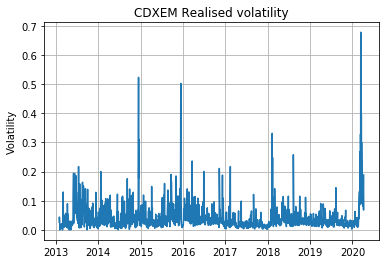

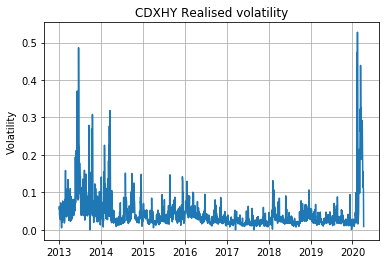

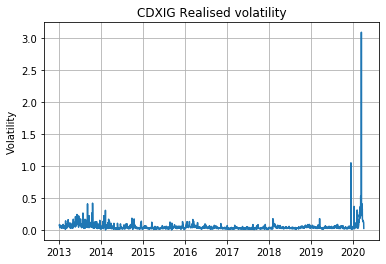

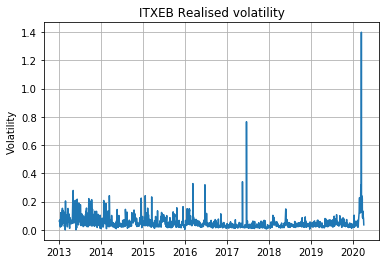

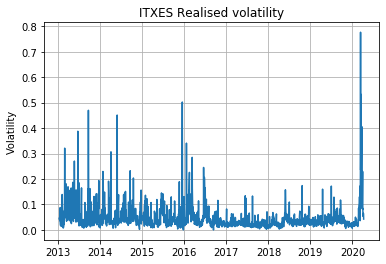

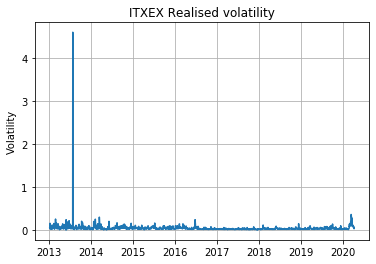

In [37]:
# Plot realised volatility
families = list(df_temp.index.get_level_values(level=0).unique())
for i in families:
    temp = df_temp.loc[i,:]
    plt.plot(temp.loc[temp['realised_volatility']<5,:].index, temp.loc[temp['realised_volatility']<5,'realised_volatility'])
    plt.ylabel('Volatility')
    plt.title(i + ' Realised volatility')
    plt.grid()
    plt.savefig('figures/' + i + '_realised_volatility.png')
    plt.show()

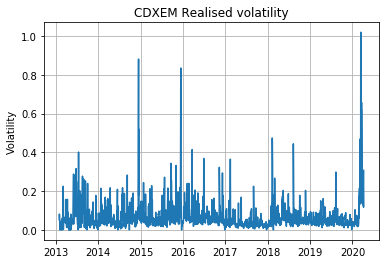

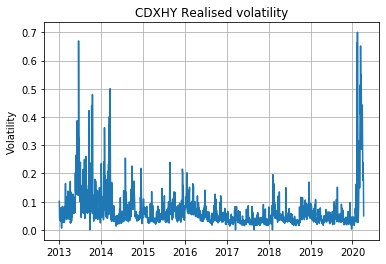

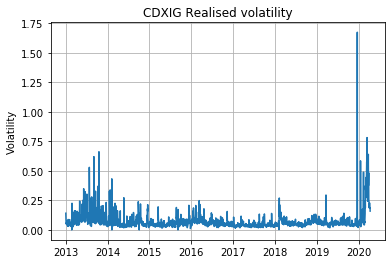

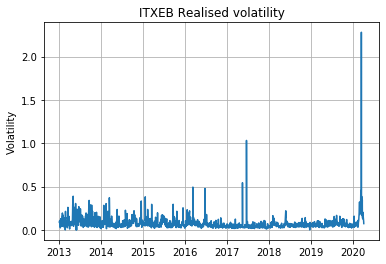

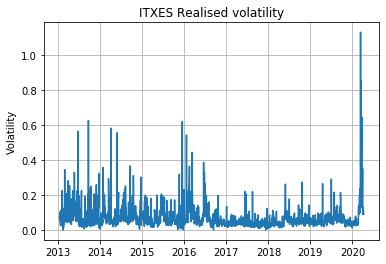

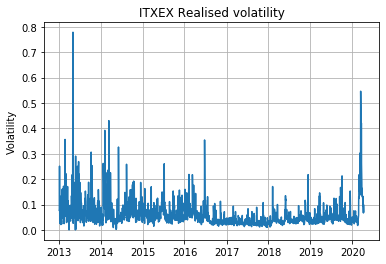

In [38]:
# Plot realised volatility
families = list(df_temp.index.get_level_values(level=0).unique())
for i in families:
    temp = df_temp.loc[i,:]
    plt.plot(temp.loc[temp['random_walk_volatility_day']<5,:].index, temp.loc[temp['random_walk_volatility_day']<5,'random_walk_volatility_day'])
    plt.ylabel('Volatility')
    plt.title(i + ' Realised volatility')
    plt.grid()
    plt.savefig('figures/' + i + '_realised_volatility.png')
    plt.show()

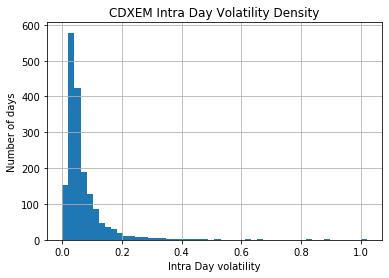

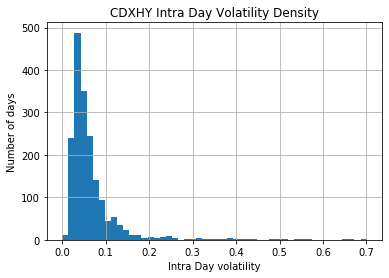

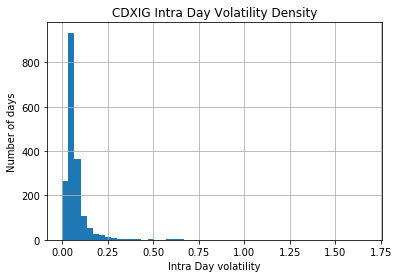

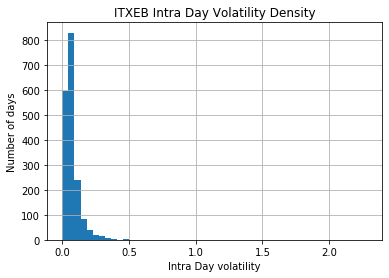

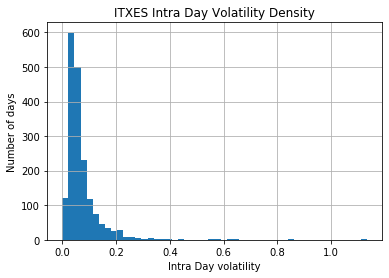

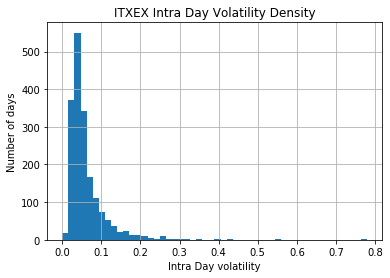

In [39]:
# Plot realised volatility
families = list(df_temp.index.get_level_values(level=0).unique())
for i in families:
    temp = df_temp.loc[i,:]
    plt.hist(temp.loc[temp['random_walk_volatility_day']<5,'random_walk_volatility_day'], bins=50)
    plt.ylabel('Number of days')
    plt.xlabel('Intra Day volatility')
    plt.title(i + ' Intra Day Volatility Density')
    plt.grid()
    plt.show()

## 4. Signature Plots 

Compute the realiused variance for specific time increments to get the signature plots.
- London market opening hours: 8 a.m. to 4:30 p.m.
- US market opening hours: 2:30 p.m. to 9 p.m.

A regular rule of thumb for computing the vairance is to have at least 12 data points, with more observations leading to a more accurate measurement. As such, since the opening market hours last 8h30 and 6h30 we will consider standard deviations starting from 30min. The following increments will be studied:
- 30 min: CDX needs 13, ITX needs at least 17  
- 20 min: CDX needs 20, ITX needs at least 26 
- 15 min: CDX needs 26, ITX needs at least 34
- 10 min: CDX needs 39, ITX needs at least 51
- 5 min: CDX needs 78, ITX needs at least 102

However, the data is more sparsely populated than we would like. We set the following guidelines. 
- Select the days where at least 95% of the time increments are populated.

We procede as follows:
- Split the dataset by family, by day and by the time increments within the market opening times.
- Find the weighted price by order size for the spreads over the time increments.
- Take the log of those spreads.
- Take the diff to compute the returns overs between time increments
- Compute the sum of the square returns over the day to have the realised variance for the day.
- Square root the results to obtained the realised volatility.
- Compute the number of Time increments where trades actually occurs.
- Take the days where at least 95% of the time increments compared have an actual trade.
- Compute the 5% 50% and 95% percentile of those results.
- Return those percentiles, ratio, and number of total trades for that day

In [40]:
df = df.reset_index().set_index(['family','valueDate'])
temp = df.groupby([pd.Grouper(level='family'),pd.Grouper(freq='D',level='valueDate')]).agg({'spread':'count'})
temp.groupby([pd.Grouper(level='family')]).agg({'spread':'mean'})

,spread
family,
CDXEM,36.757559
CDXHY,200.690241
CDXIG,160.549672
ITXEB,107.300054
ITXES,32.664859
ITXEX,103.132582


In [41]:
CDX = ['CDXEM','CDXIG','CDXHY']
ITX = ['ITXEB','ITXEX','ITXES']
INDICES = {'CDX': {'index':CDX,
                   'NbIntervals':{30:int(6.5*60/30),
                                  20:int(6.5*60/20),
                                  15:int(6.5*60/15),
                                  10:int(6.5*60/10),
                                  5:int(6.5*60/5)
                                 },
                    'OpeningTime':'14:30',
                    'ClosingTime':'21:00'
                  },
          'ITX': {'index':ITX,
                  'NbIntervals':{30:int(8.5*60/30),
                                20:int(8.5*60/20),
                                15:int(8.5*60/15),
                                10:int(8.5*60/10),
                                5:int(8.5*60/5)
                                },
                  'OpeningTime':'8:30',
                  'ClosingTime':'16:30'
                 }
        }
time_intervals = [30,20,15,10,5]
realised_cariance_signature_plot = dict()
for e, time in enumerate(time_intervals):
    i = 0
    for index in INDICES:    
        ## Compute mean weighted spread per family per day per time interval
        df_index = df.loc[INDICES[index]['index'],:].reset_index().set_index('valueDate')
        df_index = df_index.between_time(INDICES[index]['OpeningTime'], INDICES[index]['ClosingTime']).groupby(['family',pd.Grouper(freq=str(time)+'Min',level='valueDate')]).apply(lambda x: pd.Series([np.average(x['spread'], weights=x['size'])], index =['SpreadWeightedMean']))
        df_index['Nbtransactions'] =  df.loc[INDICES[index]['index'],:].reset_index().set_index('valueDate').between_time(INDICES[index]['OpeningTime'], INDICES[index]['ClosingTime']).groupby(['family',pd.Grouper(freq=str(time)+'Min',level='valueDate')]).agg({'spread':'count'})
        ## Log Average spread
        df_index['LogSpreadWeightedMean'] = np.log(df_index['SpreadWeightedMean'])
        # compute returns
        df_index['LogSpreadWeightedMean'] = pd.DataFrame(df_index.groupby([pd.Grouper(level='family'),pd.Grouper(freq='D',level='valueDate')])['LogSpreadWeightedMean'].diff())
        df_index.drop(['SpreadWeightedMean'],axis=1,inplace=True)
        df_index.columns = ['NbTransactions','Returns']
        # Square returns
        df_index['Returns'] = df_index['Returns'].apply(lambda x: x**2)
        # Set theroetical total number of intervals for time increments
        df_index['Number_intervals'] =  INDICES[index]['NbIntervals'][time]
        df_index.fillna(0,inplace=True)
        # Compute realised variance
        df_realised_volatility = df_index.groupby([pd.Grouper(level='family'),pd.Grouper(freq='D',level='valueDate')]).agg({'Returns':['count','sum'],'NbTransactions':'sum','Number_intervals':'max'})
        df_realised_volatility.columns = ['NbIntervals','RealisedVariance','TotalNbTransactions','TheoreticalNbTranscations']
        # Compute ratio of time interval sto check number of missing intervals
        df_realised_volatility['Ratio'] = df_realised_volatility['NbIntervals']/df_realised_volatility['TheoreticalNbTranscations']
        # Compute volatility by taking square root.
        df_realised_volatility['RealisedVolatility'] = df_realised_volatility['RealisedVariance'].apply(lambda x: np.sqrt(x))
        # Take days where 95% of time increment sare filled.
        df_realised_volatility= df_realised_volatility.loc[df_realised_volatility['Ratio']>0.95,:]
        # Store results in dictionary
        for j, index_type in enumerate(INDICES[index]['index']):
            if (i== 0) &(j == 0):
                if index_type not in list(df_realised_volatility.index.get_level_values(level=0).unique()):
                    realised_cariance_signature_plot[time] = {index_type:'Empty'}
                else:
                    realised_cariance_signature_plot[time] = {index_type:{'RealisedVariance':np.percentile(np.array(df_realised_volatility.loc[index_type,'RealisedVariance']),np.array([5,50,95])),
                                                             'NbIntervals':np.mean(df_realised_volatility.loc[index_type,'NbIntervals']),
                                                             'Ratio':np.mean(df_realised_volatility.loc[index_type,'Ratio']),
                                                             'NbDays':len(df_realised_volatility.loc[index_type,'Ratio'])}}
            else:
                if index_type not in list(df_realised_volatility.index.get_level_values(level=0).unique()):
                     realised_cariance_signature_plot[time].update({index_type:'Empty'})
                else:
                    realised_cariance_signature_plot[time].update({index_type:{'RealisedVariance':np.percentile(np.array(df_realised_volatility.loc[index_type,'RealisedVariance']),np.array([5,50,95])),
                                                                 'NbIntervals':np.mean(df_realised_volatility.loc[index_type,'NbIntervals']),
                                                                 'Ratio':np.mean(df_realised_volatility.loc[index_type,'Ratio']),
                                                                  'NbDays':len(df_realised_volatility.loc[index_type,'Ratio'])            
                                                                              }})
        i+=1

KeyboardInterrupt: 

In [ ]:
realised_cariance_signature_plot

In [ ]:
# Sort results per family for plotting
realised_cariance_signature_plot_dicts = dict()
for i, time in enumerate(realised_cariance_signature_plot):
    for family in INDICES:
        for index_type in realised_cariance_signature_plot[time]:
            if i == 0:
                if realised_cariance_signature_plot[time][index_type] == 'Empty':
                    realised_cariance_signature_plot_dicts[index_type] = {'x':[time],
                                                                         'y':[np.nan],
                                                                         'CI_lower':[np.nan],
                                                                         'CI_upper':[np.nan]
                                                                         }
                else:
                    realised_cariance_signature_plot_dicts[index_type] = {'x':[time],
                                                                         'y':[realised_cariance_signature_plot[time][index_type]['RealisedVariance'][1]],
                                                                         'CI_lower':[realised_cariance_signature_plot[time][index_type]['RealisedVariance'][0]],
                                                                         'CI_upper':[realised_cariance_signature_plot[time][index_type]['RealisedVariance'][2]]
                                                                        }
            else:
                if realised_cariance_signature_plot[time][index_type] == 'Empty':
                    realised_cariance_signature_plot_dicts[index_type]['x'].append(time)
                    realised_cariance_signature_plot_dicts[index_type]['y'].append(np.nan)
                    realised_cariance_signature_plot_dicts[index_type]['CI_lower'].append(np.nan)
                    realised_cariance_signature_plot_dicts[index_type]['CI_upper'].append(np.nan)    
                else:
                    realised_cariance_signature_plot_dicts[index_type]['x'].append(time)
                    realised_cariance_signature_plot_dicts[index_type]['y'].append(realised_cariance_signature_plot[time][index_type]['RealisedVariance'][1])
                    realised_cariance_signature_plot_dicts[index_type]['CI_lower'].append(realised_cariance_signature_plot[time][index_type]['RealisedVariance'][0])
                    realised_cariance_signature_plot_dicts[index_type]['CI_upper'].append(realised_cariance_signature_plot[time][index_type]['RealisedVariance'][2])            

In [ ]:
# Plot realised variance
columns = ['CDXEM','CDXIG','CDXHY','ITXEB','ITXEX','ITXES']
for i, index in enumerate(columns):
    fig, ax = plt.subplots()
    ax.plot(realised_cariance_signature_plot_dicts[index]['x'],realised_cariance_signature_plot_dicts[index]['y'], color='r')
    ax.fill_between(realised_cariance_signature_plot_dicts[index]['x'],np.array(realised_cariance_signature_plot_dicts[index]['CI_lower']), np.array(realised_cariance_signature_plot_dicts[index]['CI_upper']), color='b', alpha=.1)
    ax.grid()
    ax.axhline(color='k')
    ax.set(xlabel = 'Time intervals length in minutes (min)', ylabel = 'Realised Variance', title = index + ' Realised variance as a function of grid size' )
    plt.savefig('figures/' + index + '_Signature_Plots.eps')
plt.tight_layout()

In [ ]:
columns = ['CDXEM','CDXIG','CDXHY','ITXEB','ITXEX','ITXES']
temp = pd.DataFrame(df.groupby([pd.Grouper(level='family'),pd.Grouper(freq='D',level='valueDate')])['log_spread'].diff()).dropna()

In [ ]:
temp['count'] = temp.groupby([pd.Grouper(level='family'),pd.Grouper(freq='D',level='valueDate')]).transform('count')
count1 = pd.DataFrame(temp.groupby([pd.Grouper(level='family'),pd.Grouper(freq='D',level='valueDate')])['log_spread'].count())

In [ ]:
count1

In [ ]:
columns = ['CDXEM','CDXIG','CDXHY','ITXEB','ITXEX','ITXES']
frequency = [' Low liquidity', ' medium liquidity', ' high liquidity']
for index in columns:
    values = np.percentile(list(count1.loc[index,'log_spread']), [5,50,95])
    temp1 = temp.loc[index,:]
    for i, value in enumerate(values):
        plt.hist(temp1.loc[temp1['count']==value,'log_spread'], bins = 30)
        plt.grid()
        plt.xlabel('Returns')
        plt.ylabel('Number of Days')
        plt.title(index + frequency[i])
        plt.show()

## 5. Clustering

We will try a simple clustering method. In order to do that, we computed several new features:
- The mean return for a specific day.
- The volatility for a specific day.
- The Wasserstein distance between each return pairs for a specific day.
- The Wasserstein distance for the returns for each day and family and its previous day's distribution.

We will test different clustering methods:
- Cluster CDX and ITX as a whole. This is because the there is little correlation between each family.
- Each credit index swaps individually.

The following clustering methods will be used:
- kmeans
- DBSCAN
- Spectral Clustering

### 5.1. Feature Engineering

#### 5.1.1. Returns 

In [ ]:
# Compute daily returns
df_returns = pd.DataFrame(df.groupby([pd.Grouper(level='family'),pd.Grouper(freq='D',level='valueDate')])['log_spread'].diff()).dropna().unstack(level=0)
df_returns.columns = df_returns.columns.get_level_values(level=1)

#### 5.1.2. Daily inter credit index swap Wasserstein distance

We will compute the wasserstein distance between the returns for each indices within each family. The wasserstein distance computes the following:
-  The Wasserstein distance is the minimum cost of transporting mass in converting the data distribution $X$ ~ $\mu$ to the data distribution $Y$ ~ $\nu$.
- It is defined as follows: $$ W_p(\mu, \nu) = inf_{X~\mu,Y~\nu} (E||X − Y||^p)^{1/p} , p \geq 1,$$
    - Where the infimum is taken over all pairs of d-dimensional random vectors X and Y marginally distributed as μ and ν
- It will give us an approximation of how far appart are each distributions.

In [ ]:
# CDX family indices
CDX = ['CDXEM', 'CDXIG', 'CDXHY']
# ITX family indices
ITX = ['ITXEB', 'ITXEX', 'ITXES']

# Compute Wasserstein Distance For CDX families
for i, family in enumerate(CDX):
    for j, index in enumerate(CDX[i+1:]):   
        # Add a column of total number of trades within a day
        df_returns[[family+'_count',index+'_count']] = df_returns[[family,index]].groupby(pd.Grouper(freq='D')).transform('count')
        # Select days where both families have trades within days
        df_returns_days_with_trades = df_returns[(df_returns[[family+'_count',index+'_count']].values != 0).all(1)]
        df_returns_days_with_trades.reset_index(inplace=True)
        # Compute wasserstein distance between the two families for each day
        df_wasserstein_distance = pd.DataFrame(df_returns_days_with_trades[[family,
                                                          index]].groupby(df_returns_days_with_trades['valueDate'].dt.date
                                                                         ).apply(lambda x: stats.wasserstein_distance(x[family].dropna()
                                                                                                                      ,x[index].dropna()
                                                                                                                     )
                                                                                )
                            )
        df_wasserstein_distance.columns = [family+'_'+index]
        if i == 0 and j == 0:
            df_CDX = df_wasserstein_distance
        else:
            df_CDX = df_CDX.merge(df_wasserstein_distance, how='outer',left_index=True,right_index=True)

# Compute Wasserstein Distance For ITX families
for i, family in enumerate(ITX):
    for j, index in enumerate(ITX[i+1:]):   
        # Add a column of total number of trades within a day
        df_returns[[family+'_count',index+'_count']] = df_returns[[family,index]].groupby(pd.Grouper(freq='D')).transform('count')
        # Select days where both families have trades within days
        df_returns_days_with_trades = df_returns[(df_returns[[family+'_count',index+'_count']].values != 0).all(1)]
        df_returns_days_with_trades.reset_index(inplace=True)
        # Compute wasserstein distance between the two families for each day
        df_wasserstein_distance = pd.DataFrame(df_returns_days_with_trades[[family,index]
                                                                          ].groupby(df_returns_days_with_trades['valueDate'].dt.date
                                                                                   ).apply(lambda x: stats.wasserstein_distance(x[family].dropna(),
                                                                                                                                x[index].dropna()
                                                                                                                               )
                                                                                          )
                                              )
        df_wasserstein_distance.columns = [family+'_'+index]
        if i == 0 and j == 0:
            df_ITX = df_wasserstein_distance
        else:
            df_ITX = df_ITX.merge(df_wasserstein_distance, how='outer',left_index=True,right_index=True)

#### 5.1.3. Daily Wasserstein distance to previous family

In [ ]:
# CDX returns shift to previous business day
for i in CDX:
    df_returns_shifted = pd.DataFrame(df_returns[i].shift(1, freq='B'))
    df_returns_shifted.columns = [i+'_1']
    df_returns = df_returns.merge(df_returns_shifted, how='left',left_index=True, right_index=True)

# Compute the wasserstein distance for each index to its previous day's distribution
for i, family in enumerate(CDX):
    df_returns[[family+'_count',family+'_1_count']] = df_returns[[family,family+'_1']].groupby(pd.Grouper(freq='D')).transform('count')
    # keep all days with trades taking place
    df_returns_days_with_trades = df_returns[(df_returns[[family+'_count',family+'_1_count']].values != 0).all(1)]
    df_returns_days_with_trades.reset_index(inplace=True)
    # Compute Wasserstein distance to the previous day's distribution
    df_wasserstein_distance = pd.DataFrame(df_returns_days_with_trades[[family,family+'_1']
                                                                      ].groupby(df_returns_days_with_trades['valueDate'].dt.date
                                                                               ).apply(lambda x: stats.wasserstein_distance(x[family].dropna(),
                                                                                                                            x[family+'_1'].dropna()
                                                                                                                           )
                                                                                      )
                                          )
    df_wasserstein_distance.columns = [family+'_1']
    if i == 0:
        df_final_inter_day_CDX = df_wasserstein_distance
    else:
        df_final_inter_day_CDX = df_final_inter_day_CDX.merge(df_wasserstein_distance, how='outer',left_index=True,right_index=True)
        
# ITX returns shift to previous business day
for i in ITX:
    df_returns_shifted = pd.DataFrame(df_returns[i].shift(1, freq='B'))
    df_returns_shifted.columns = [i+'_1']
    df_returns = df_returns.merge(df_returns_shifted, how='left',left_index=True, right_index=True)
    
# Compute the wasserstein distance for each index to its previous day's distribution
for i, family in enumerate(ITX):
    df_returns[[family+'_count',family+'_1_count']] = df_returns[[family,family+'_1']].groupby(pd.Grouper(freq='D')).transform('count')
    # keep all days with trades taking place
    df_returns_days_with_trades = df_returns[(df_returns[[family+'_count',family+'_1_count']].values != 0).all(1)]
    df_returns_days_with_trades.reset_index(inplace=True)
    # Compute Wasserstein distance to the previous day's distribution
    df_wasserstein_distance = pd.DataFrame(df_returns_days_with_trades[[family,family+'_1']
                                                                      ].groupby(df_returns_days_with_trades['valueDate'].dt.date
                                                                               ).apply(lambda x: stats.wasserstein_distance(x[family].dropna(),
                                                                                                                            x[family+'_1'].dropna()
                                                                                                                           )
                                                                                      )
                                          )
    df_wasserstein_distance.columns = [family+'_1']
    if i == 0:
        df_final_inter_day_ITX = df_wasserstein_distance
    else:
        df_final_inter_day_ITX = df_final_inter_day_ITX.merge(df_wasserstein_distance, how='outer',left_index=True,right_index=True)

#### 5.1.4. Returns Mean

In [ ]:
# CDX daily return mean
CDX_mean = [x+'_mean' for x in CDX]
df_CDX_mean = df_returns[CDX].groupby(pd.Grouper(freq='D')).mean()
df_CDX_mean.columns = CDX_mean
df_CDX_mean.dropna(how='all', inplace=True)

In [ ]:
# ITX daily return mean
ITX_mean = [x+'_mean' for x in ITX]
df_ITX_mean = df_returns[ITX].groupby(pd.Grouper(freq='D')).mean()
df_ITX_mean.columns = ITX_mean
df_ITX_mean.dropna(how='all', inplace=True)

#### 5.1.5. Daily returns volatility

In [ ]:
# CDX daily return volatility
df_volatility = df_temp[['random_walk_volatility_day']].unstack(level=0)
df_volatility.columns = df_volatility.columns.get_level_values(level=1)
df_volatility_CDX = df_volatility[CDX]
df_volatility_CDX.columns= [x+'_volatility' for x in list(df_volatility_CDX.columns)]
#remove outliers:
df_volatility_CDX = df_volatility_CDX[np.abs(df_volatility_CDX)<1]
# ITX daily return volatility
df_volatility_ITX = df_volatility[ITX]
df_volatility_ITX.columns= [x+'_volatility' for x in list(df_volatility_ITX.columns)]
# remove outliers
df_volatility_ITX = df_volatility_ITX[np.abs(df_volatility_ITX)<1]

#### 5.1.6. Daily returns correlation

In [ ]:
df_CDX_correlation = df_intraday_correlation[['CDXEM_CDXHY','CDXEM_CDXIG','CDXHY_CDXIG']]

In [ ]:
df_CDX_correlation.columns = ['CDXEM_CDXHY_corr','CDXEM_CDXIG_corr','CDXHY_CDXIG_corr']

In [ ]:
df_ITX_correlation = df_intraday_correlation[['ITXEB_ITXES','ITXEB_ITXEX','ITXES_ITXEX']]

In [ ]:
df_ITX_correlation.columns = ['ITXEB_ITXES_corr','ITXEB_ITXEX_corr','ITXES_ITXEX_corr']

#### 5.1.6. Final Feature engineered dataset

In [ ]:
df_CDX = df_CDX.merge(df_CDX_mean,how='outer',left_index=True, right_index=True)
df_CDX = df_CDX.merge(df_volatility_CDX,how='outer',left_index=True, right_index=True)
df_CDX = df_CDX.merge(df_final_inter_day_CDX,how='outer',left_index=True, right_index=True)
df_CDX = df_CDX.merge(df_CDX_correlation,how='outer',left_index=True, right_index=True)


df_ITX = df_ITX.merge(df_ITX_mean,how='outer',left_index=True, right_index=True)
df_ITX = df_ITX.merge(df_volatility_ITX,how='outer',left_index=True, right_index=True)
df_ITX = df_ITX.merge(df_final_inter_day_ITX,how='outer',left_index=True, right_index=True)
df_ITX = df_ITX.merge(df_ITX_correlation,how='outer',left_index=True, right_index=True)

### 5.2. Credit Index Swaps Families

#### 5.2.1. CDX Family

##### 5.2.1.1. Kmeans

We start by exploring a kmeans clustering. This method consists of the following steps:
- Define the number of clusters.
- Assign the clusters to specific data points. These will be the initial cluster centroids.
- Compute for each dasta point the euclidean distance to the cluster centroids.
- Assign each data points to the nearest cluster centroid.
- Compute the new centroid for each cluster, and iterate the previous steps until convergence.

This method is very intuitive, however there are certain drawbacks:
- It assumes that the clusters are of convex shape.
- The clusters are dependent on the intial assignement.
- The number of clusters are user defined.

In order to remedy this, we choose the number of clusters we want using the elbow method. In order to accomplish this, we use the Within-Cluster-Sum of Squared Errors (WCSS) for different values number of clusters k. We then choose k, when the gradient of the curve wcss vs k starts to decrease. The WCSS is defined as the sum of all the observations' distances to their respective cluster centroids. As WCSS decreses, we have more compact clusters

In [ ]:
# Within cluster sum of squared errors.
wcss = []
# dropna
df_CDX_family = df_CDX.dropna()
for i in range(2,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=100, random_state=0)
    kmeans.fit(df_CDX_family)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 20), wcss)
plt.title('Elbow Method CDX indices')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.savefig('figures/CDXcluster.eps')

After analysing the graph, it seems that 4 clusters represents an approiate number of cluster

In [ ]:
df_CDX_family

In [ ]:
# Compute clusters
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=1000, n_init=100, random_state=0)
kmeans.fit(df_CDX_family)
df_CDX_family['Cluster_kmeans_5'] = kmeans.predict(df_CDX_family)
df_CDX_family.groupby('Cluster_kmeans_5').count()
# Compute clusters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=1000, n_init=100, random_state=0)
kmeans.fit(df_CDX_family)
df_CDX_family['Cluster_kmeans_3'] = kmeans.predict(df_CDX_family)
df_CDX_family.groupby('Cluster_kmeans_3').count()

In [ ]:
df_CDX_family_mean = df_CDX_family.groupby('Cluster_kmeans_5').mean()

In [ ]:
df_CDX_family_mean

In [ ]:
df_CDX_family_mean.rank()

- Cluster 1: Lowest distribution Wasserstein Distance 2-1, lowest negative mean 2-1, lowest volatility 2-1, low interday Wasserstein distance 2, medium-high correlation 3-5
- Cluster 2: High Wasserstein return distribution distance 4, medium mean 2-4, high volatility 4, high inter day returns Wasserstein distance 4, medium high correlation 4-2.
- Cluster 3: Medium Wasserstein return distribution distance 3, medium mean 3-4, medium volatility 3, medium inter day returns distribution Wasserstein distance 3-4, low-medium correlation 1-3.
- Cluster 4: Low Wasserstein return distribution distance 1-2, medium mean 1-2-4, low volatility 1-2, low inter day returns Wasserstein distance 1, high correlation 5.
- Cluster 5: High Wasserstein returns distribution distance 5, high mean 5, high volatility 5, high inter day returns Wasserstein distance 5, low correlation 1-2. 

Therefore from the clusters we are able to determine that:
- Cluster 1: Low volatility linked to a negative mean of returns, similar distributions for the returns of different indexes and similar inter day returns distribtuions. Moreover the returns are closely correlated.
- Cluster 2: Different inter day returns distribution are linked to intra day differences and a lafge volatility. They are linked to a null mean.
- Cluster 3: inter day returns distribution are linked to intra day differences and volatility. They are linked to a null mean.
- Cluster 4: Same intra and inter day distributions, low means, low volatility and high distributions.
- Cluster 5: Very high correlation between each feature when the values are high, eg: high mean and high difference in distributions

Overall we can determine that the features Wassersteins distances (inter and intra day), volatility and mean are highly correlated with each other.

In [ ]:
fig, ax = plt.subplots(12,4, figsize=(30,30))
legends = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
for i in range(12):
    for j in range(4):
        ax[i,j].hist(df_CDX_family.loc[df_CDX_family['Cluster_kmeans_5']==j,list(df_CDX_family.columns)[i]])
        ax[i,j].set(ylabel='Density',xlabel=list(df_CDX_family.columns)[i], title=legends[j])
        ax[i,j].grid()
plt.tight_layout()

##### 5.2.1.2. Spectral Clustering

In [ ]:
# Compute for different number of clusters
clustering = SpectralClustering(n_clusters=3, assign_labels="discretize", random_state=0, n_init=100).fit(df_CDX_family.drop(['Cluster_kmeans_3','Cluster_kmeans_5'], axis=1))
# Affinity matrix
A = clustering.affinity_matrix_
# Degree matrix
D = np.diag(A.sum(axis=1))
# Graph Laplacian matrix
GL = D - A
# Compute eigenvector and eigenvalues
w, v  = np.linalg.eig(GL)
plt.scatter(range(10),w[:10])
plt.grid()
plt.show()

After analysing the plot, we determine that the largest fisrt increase in eigenvalue is between eignevalue 3 and 4. So we will choose 3 clusters for the spectral clustering scan.

In [ ]:
clustering = SpectralClustering(n_clusters= 3, assign_labels="discretize", random_state=0, n_init=100).fit(df_CDX_family)

In [ ]:
df_CDX_family['Clustering_SpectralClustering'] = clustering.labels_

In [ ]:
df_CDX_family.groupby('Clustering_SpectralClustering').count()

In [ ]:
df_CDX_family.groupby('Clustering_SpectralClustering').mean()

#### 5.2.2. ITX

##### 5.2.2.1. KMeans

In [ ]:
# Within cluster sum of squared errors.
wcss = []
# dropna
df_ITX_family = df_ITX.dropna()
for i in range(2,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=100, random_state=0)
    kmeans.fit(df_ITX_family)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 20), wcss)
plt.title('Elbow Method ITX indices')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.savefig('figures/ITXclusters.eps')
plt.show()

In [ ]:
# Compute clusters
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=1000, n_init=100, random_state=0)
kmeans.fit(df_ITX_family)
df_ITX_family['Cluster_kmeans_5'] = kmeans.predict(df_ITX_family)
df_ITX_family.groupby('Cluster_kmeans_5').count()
# Compute clusters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=1000, n_init=100, random_state=0)
kmeans.fit(df_ITX_family)
df_ITX_family['Cluster_kmeans_3'] = kmeans.predict(df_ITX_family)
df_ITX_family.groupby('Cluster_kmeans_3').count()

In [ ]:
df_ITX_family.groupby('Cluster_kmeans_5').mean()

In [ ]:
fig, ax = plt.subplots(12,4, figsize=(30,30))
legends = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
for i in range(12):
    for j in range(4):
        ax[i,j].hist(df_ITX_family.loc[df_ITX_family['Cluster_kmeans_5']==j,list(df_ITX_family.columns)[i]])
        ax[i,j].set(ylabel='Density',xlabel=list(df_ITX_family.columns)[i], title=legends[j])
        ax[i,j].grid()
plt.tight_layout()

##### 5.2.2.2. Spectral Clustering

In [ ]:
# Compute for different number of clusters
clustering = SpectralClustering(n_clusters=3, assign_labels="discretize", random_state=0, n_init=100).fit(df_ITX_family.drop(['Cluster_kmeans_5','Cluster_kmeans_3'],axis=1))
# Affinity matrix
A = clustering.affinity_matrix_
# Degree matrix
D = np.diag(A.sum(axis=1))
# Graph Laplacian matrix
GL = D - A
# Compute eigenvector and eigenvalues
w, v  = np.linalg.eig(GL)
plt.scatter(range(10),w[:10])
plt.grid()
plt.show()

We have the first large increase in value between eigenvalue 2 and 3, which mens we will select 2 clusters for the Spectral Clustering method.

In [ ]:
clustering = SpectralClustering(n_clusters= 2, assign_labels="discretize", random_state=0, n_init=100).fit(df_ITX_family)

In [ ]:
df_ITX_family['Clustering_SpectralClustering'] = clustering.labels_

In [ ]:
df_ITX_family.groupby('Clustering_SpectralClustering').count()

In [ ]:
df_ITX_family.groupby('Clustering_SpectralClustering').mean()

In [ ]:
fig, ax = plt.subplots(12,2, figsize=(30,30))
legends = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
for i in range(12):
    for j in range(2):
        ax[i,j].hist(df_ITX_family.loc[df_ITX_family['Clustering_SpectralClustering']==j,list(df_ITX_family.columns)[i]])
        ax[i,j].set(ylabel='Density',xlabel=list(df_ITX_family.columns)[i], title=legends[j])
        ax[i,j].grid()
plt.tight_layout()

### 5.3. CDXEM

#### 5.3.1. KMeans

In [ ]:
df_CDX_family

In [ ]:
df_CDXEM = df_CDX[['CDXEM_mean','CDXEM_1','CDXEM_volatility']]

In [ ]:
# Within cluster sum of squared errors.
wcss = []
# dropna
df_CDXEM.dropna(inplace=True)
for i in range(2,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=100, random_state=0)
    kmeans.fit(df_CDXEM)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=100, random_state=0)
kmeans.fit(df_CDXEM)

In [ ]:
df_CDXEM['Clusters_kmeans'] = kmeans.labels_

In [ ]:
df_CDXEM.groupby('Clusters_kmeans').count()

In [ ]:
df_CDXEM.groupby('Clusters_kmeans').mean()

#### 5.3.2. Spectral Clustering

In [ ]:
# Compute for different number of clusters
clustering = SpectralClustering(n_clusters=3, assign_labels="discretize", random_state=0, n_init=100).fit(df_CDXEM)
# Affinity matrix
A = clustering.affinity_matrix_
# Degree matrix
D = np.diag(A.sum(axis=1))
# Graph Laplacian matrix
GL = D - A
# Compute eigenvector and eigenvalues
w, v  = np.linalg.eig(GL)
plt.scatter(range(10),w[:10])
plt.grid()
plt.show()

The first largest increase in eigenvalues is between the 2nd and 3rd eignevalue. As a consequence, we will choose 2 clusters

In [ ]:
clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=0, n_init=100).fit(df_CDXEM)
df_CDXEM['Clustering_SpectralClustering'] = clustering.labels_

In [ ]:
df_CDXEM.groupby('Clustering_SpectralClustering').count()

In [ ]:
df_CDXEM.groupby('Clustering_SpectralClustering').mean()

### 5.4. CDXIG

#### 5.4.1. KMeans

In [ ]:
df_CDXIG = df_CDX[['CDXIG_mean','CDXIG_1','CDXIG_volatility']]

In [ ]:
# Within cluster sum of squared errors.
wcss = []
# dropna
df_CDXIG.dropna(inplace=True)
for i in range(2,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=100, random_state=0)
    kmeans.fit(df_CDXIG)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=100, random_state=0)
kmeans.fit(df_CDXIG)

Using the elbow method we choose the number of clusters. We therefore have 4 clusters.

In [ ]:
df_CDXIG['Clusters_kmeans'] = kmeans.labels_

In [ ]:
df_CDXIG.groupby('Clusters_kmeans').count()

In [ ]:
df_CDXIG.groupby('Clusters_kmeans').mean()

### 5.5. CDXHY

#### 5.5.1. Kmeans

In [ ]:
df_CDXHY = df_CDX[['CDXHY_mean','CDXHY_1','CDXHY_volatility']]

In [ ]:
# Within cluster sum of squared errors.
wcss = []
# dropna
df_CDXHY.dropna(inplace=True)
for i in range(2,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=100, random_state=0)
    kmeans.fit(df_CDXHY)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=100, random_state=0)
kmeans.fit(df_CDXHY)

In [ ]:
df_CDXHY['Clusters_kmeans'] = kmeans.labels_

In [ ]:
df_CDXHY.groupby('Clusters_kmeans').count()

In [ ]:
df_CDXHY.groupby('Clusters_kmeans').mean()

### 5.6. ITXES

##### 5.6.1. kmeans 

In [ ]:
df_ITXEB = df_ITX[['ITXEB_mean','ITXEB_1','ITXEB_volatility']]

In [ ]:
# Within cluster sum of squared errors.
wcss = []
# dropna
df_ITXEB.dropna(inplace=True)
for i in range(2,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=100, random_state=0)
    kmeans.fit(df_ITXEB)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=100, random_state=0)
kmeans.fit(df_ITXEB)

In [ ]:
df_ITXEB['Clusters_kmeans'] = kmeans.labels_

In [ ]:
df_ITXEB.groupby('Clusters_kmeans').count()

In [ ]:
df_ITXEB.groupby('Clusters_kmeans').mean()

### 5.7. ITXES

#### 5.7.1. Kmeans

In [ ]:
df_ITXES = df_ITX[['ITXES_mean','ITXES_1','ITXES_volatility']]

In [ ]:
# Within cluster sum of squared errors.
wcss = []
# dropna
df_ITXES.dropna(inplace=True)
for i in range(2,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=100, random_state=0)
    kmeans.fit(df_ITXES)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=100, random_state=0)
kmeans.fit(df_ITXES)

In [ ]:
df_ITXES['Clusters_kmeans'] = kmeans.labels_

In [ ]:
df_ITXES.groupby('Clusters_kmeans').count()

In [ ]:
df_ITXES.groupby('Clusters_kmeans').mean()

### 5.8. ITXEX

#### 5.8.1 kmeans

In [ ]:
df_ITXEX = df_ITX[['ITXEX_mean','ITXEX_1','ITXEX_volatility']]

In [ ]:
# Within cluster sum of squared errors.
wcss = []
# dropna
df_ITXEX.dropna(inplace=True)
for i in range(2,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=100, random_state=0)
    kmeans.fit(df_ITXEX)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=100, random_state=0)
kmeans.fit(df_ITXEX)

In [ ]:
df_ITXEX['Clusters_kmeans'] = kmeans.labels_

In [ ]:
df_ITXEX.groupby('Clusters_kmeans').count()

In [ ]:
df_ITXEX.groupby('Clusters_kmeans').mean()

## 7. Predictions

### 7.1 Next day cluster predicition

In [ ]:
df_CDX_family['Cluster_kmeans_5_1'] = df_CDX_family['Cluster_kmeans_5'].shift(-1)
df_CDX_family['Cluster_kmeans_3_1'] = df_CDX_family['Cluster_kmeans_3'].shift(-1)
df_CDX_family.dropna(inplace=True)
y_5 = df_CDX_family['Cluster_kmeans_5'].values
y_5_fut = df_CDX_family['Cluster_kmeans_5_1'].values
y_3 = df_CDX_family['Cluster_kmeans_3'].values
y_3_fut = df_CDX_family['Cluster_kmeans_3_1'].values
X = df_CDX_family.drop(['Cluster_kmeans_5','Cluster_kmeans_5_1','Cluster_kmeans_3','Cluster_kmeans_3_1','Clustering_SpectralClustering',], axis=1).values

In [ ]:
df_ITX_family['Cluster_kmeans_5_1'] = df_ITX_family['Cluster_kmeans_5'].shift(-1)
df_ITX_family['Cluster_kmeans_3_1'] = df_ITX_family['Cluster_kmeans_3'].shift(-1)
df_ITX_family.dropna(inplace=True)
y_5 = df_ITX_family['Cluster_kmeans_5'].values
y_5_fut = df_ITX_family['Cluster_kmeans_5_1'].values
y_3 = df_ITX_family['Cluster_kmeans_3'].values
y_3_fut = df_ITX_family['Cluster_kmeans_3_1'].values
X = df_ITX_family.drop(['Cluster_kmeans_5','Cluster_kmeans_5_1','Cluster_kmeans_3','Cluster_kmeans_3_1'], axis=1).values

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X, y_5, random_state=42)
X_train_5_fut, X_test_5_fut, y_train_5_fut, y_test_5_fut = train_test_split(X, y_5_fut, random_state=42)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y_3, random_state=42)
X_train_3_fut, X_test_3_fut, y_train_3_fut, y_test_3_fut = train_test_split(X, y_3_fut, random_state=42)

In [ ]:
gsc = GridSearchCV(estimator=RandomForestClassifier(),
                   param_grid={'max_depth': range(3,7),
                               'n_estimators': (10, 50, 100, 1000),
                              },
                   cv=5,
                   scoring='neg_mean_squared_error',
                   verbose=0,
                   n_jobs=-1
                  )
grid_result_5 = gsc.fit(X_train_5, y_train_5)
best_params_5 = grid_result_5.best_params_

gsc = GridSearchCV(estimator=RandomForestClassifier(),
                   param_grid={'max_depth': range(3,7),
                               'n_estimators': (10, 50, 100, 1000),
                              },
                   cv=5,
                   scoring='neg_mean_squared_error',
                   verbose=0,
                   n_jobs=-1
                  )
grid_result_5_fut = gsc.fit(X_train_5_fut, y_train_5_fut)
best_params_5_fut = grid_result_5_fut.best_params_

In [ ]:
rfc_5 = RandomForestClassifier(max_depth=best_params_5["max_depth"],
                            n_estimators=best_params_5["n_estimators"],
                            random_state=False,
                            verbose=False
                           )
rfc_5.fit(X_train_5,y_train_5)

rfc_5_fut = RandomForestClassifier(max_depth=best_params_5_fut["max_depth"],
                            n_estimators=best_params_5_fut["n_estimators"],
                            random_state=False,
                            verbose=False
                           )
rfc_5_fut.fit(X_train_5_fut,y_train_5_fut)

In [ ]:
y_pred_5 = rfc_5.predict(X_test_5)
y_pred_5_fut = rfc_5_fut.predict(X_test_5_fut)

In [ ]:
accuracy = accuracy_score(y_test_5, y_pred_5)
f1 = f1_score(y_test_5, y_pred_5,average='macro')
print('accuracy: '+str(accuracy))
print('f1 score: '+str(f1))
accuracy = accuracy_score(y_test_5_fut, y_pred_5_fut)
f1 = f1_score(y_test_5_fut, y_pred_5_fut,average='macro')
print('accuracy: '+str(accuracy))
print('f1 score: '+str(f1))

In [ ]:
gsc = GridSearchCV(estimator=RandomForestClassifier(),
                   param_grid={'max_depth': range(3,7),
                               'n_estimators': (10, 50, 100, 1000),
                              },
                   cv=5,
                   scoring='neg_mean_squared_error',
                   verbose=0,
                   n_jobs=-1
                  )
grid_result_3 = gsc.fit(X_train_3, y_train_3)
best_params_3 = grid_result_3.best_params_

gsc = GridSearchCV(estimator=RandomForestClassifier(),
                   param_grid={'max_depth': range(3,7),
                               'n_estimators': (10, 50, 100, 1000),
                              },
                   cv=5,
                   scoring='neg_mean_squared_error',
                   verbose=0,
                   n_jobs=-1
                  )
grid_result_3_fut = gsc.fit(X_train_3_fut, y_train_3_fut)
best_params_3_fut = grid_result_3_fut.best_params_

In [ ]:
rfc_3 = RandomForestClassifier(max_depth=best_params_3["max_depth"],
                            n_estimators=best_params_3["n_estimators"],
                            random_state=False,
                            verbose=False
                           )
rfc_3.fit(X_train_3,y_train_3)

rfc_3_fut = RandomForestClassifier(max_depth=best_params_3_fut["max_depth"],
                            n_estimators=best_params_3_fut["n_estimators"],
                            random_state=False,
                            verbose=False
                           )
rfc_3_fut.fit(X_train_3_fut,y_train_3_fut)

In [ ]:
y_pred_3 = rfc_3.predict(X_test_3)
y_pred_3_fut = rfc_3_fut.predict(X_test_3_fut)

In [ ]:
accuracy = accuracy_score(y_test_3, y_pred_3)
f1 = f1_score(y_test_3, y_pred_3,average='macro')
print('accuracy: '+str(accuracy))
print('f1 score: '+str(f1))
accuracy = accuracy_score(y_test_3_fut, y_pred_3_fut)
f1 = f1_score(y_test_3_fut, y_pred_3_fut,average='macro')
print('accuracy: '+str(accuracy))
print('f1 score: '+str(f1))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
y_pred_fut = y_pred_fut.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)

In [ ]:
y_pred_fut.shape

In [ ]:
plot_confusion_matrix(y_test_fut, y_pred_fut,normalize=True)
np.set_printoptions(precision=2)

In [ ]:
df_ITX_family['Cluster_kmeans_1'] = df_ITX_family['Cluster_kmeans'].shift(-1)

In [ ]:
df_ITX_family.dropna(inplace=True)

In [ ]:
y = df_ITX_family['Cluster_kmeans'].values
X = df_ITX_family.drop(['Cluster_kmeans','Clustering_SpectralClustering'], axis=1).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
X_train_fut, X_test_fut, y_train_fut, y_test_fut = train_test_split(X, y, random_state=42)

In [ ]:
gsc = GridSearchCV(estimator=RandomForestClassifier(),
                   param_grid={'max_depth': range(3,7),
                               'n_estimators': (10, 50, 100, 1000),
                              },
                   cv=5,
                   scoring='neg_mean_squared_error',
                   verbose=0,
                   n_jobs=-1
                  )
grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

In [ ]:
gsc_fut = GridSearchCV(estimator=RandomForestClassifier(),
                   param_grid={'max_depth': range(3,7),
                               'n_estimators': (10, 50, 100, 1000),
                              },
                   cv=5,
                   scoring='neg_mean_squared_error',
                   verbose=0,
                   n_jobs=-1
                  )
grid_result_fut = gsc_fut.fit(X_train_fut, y_train_fut)
best_params_fut = grid_result_fut.best_params_

In [ ]:
rfc = RandomForestClassifier(max_depth=best_params["max_depth"],
                            n_estimators=best_params["n_estimators"],
                            random_state=False,
                            verbose=False
                           )
rfc.fit(X_train,y_train)

In [ ]:
rfc_fut = RandomForestClassifier(max_depth=best_params_fut["max_depth"],
                            n_estimators=best_params_fut["n_estimators"],
                            random_state=False,
                            verbose=False
                           )
rfc_fut.fit(X_train_fut,y_train_fut)

In [ ]:
y_pred = rfc.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,average='macro')

In [ ]:
print('accuracy: '+str(accuracy))
print('f1 score: '+str(f1))

In [ ]:
X_train.shape

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# groupby family and by day
df.reset_index(inplace=True)
df.set_index('valueDate', inplace=True)
g = df.groupby(['family',pd.Grouper(freq='D')])
# Create variable of weighted mean of spreads by size of transaction per day
df_statistics = g.apply(lambda x: pd.Series([np.average(x['spread'], weights=x['size'])], index =['SpreadWeightedMean']))
# Create variable of mean of spreads of trades per day
df_statistics['SpreadMean'] = df.groupby(['family',pd.Grouper(freq = 'D')]).agg({'spread':'mean'})
# Create variable of log of spreads
df_statistics['LogSpreadWeightedMean'] = np.log(df_statistics['SpreadWeightedMean'])

In [ ]:
df_temp = df_statistics[['LogSpreadWeightedMean']].unstack(level=0)

In [ ]:
df_temp.columns = df_temp.columns.get_level_values(level=1)

In [ ]:
df_temp

In [ ]:
df_CDX_family.columns

In [ ]:
df_CDX_family = df_CDX_family.merge(df_temp[['CDXEM','CDXHY','CDXIG']], how='left', left_index=True, right_index=True)

In [ ]:
df_CDX_family['CDXEM_1'] = df_CDX_family['CDXEM'].shift(-1)
df_CDX_family['CDXIG_1'] = df_CDX_family['CDXIG'].shift(-1)
df_CDX_family['CDXHY_1'] = df_CDX_family['CDXHY'].shift(-1)

In [ ]:
df_CDX_family.dropna(inplace=True)

In [ ]:
y = df_CDX_family['CDXEM_1'].values
X = df_CDX_family.drop(['Cluster_kmeans_5',
                        'Cluster_kmeans_3',
                        'Clustering_SpectralClustering',
                        'Cluster_kmeans_5_1',
                        'Cluster_kmeans_3_1',
                        'CDXEM',
                        'CDXHY',
                        'CDXIG',
                        'CDXEM_1',
                        'CDXHY_1',
                        'CDXIG_1'],
                       axis=1
                      ).values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
df_CDX_family.drop(['Cluster_kmeans_5',
                    'Cluster_kmeans_3',
                    'Clustering_SpectralClustering',
                    'Cluster_kmeans_5_1', 
                    'Cluster_kmeans_3_1',
                    'CDXEM',
                    'CDXHY',
                    'CDXIG',
                    'CDXEM_1',
                    'CDXHY_1',
                    'CDXIG_1'],
                   axis=1
                  ).columns

In [ ]:
y_train = y_train.reshape(-1,1)

In [ ]:
X_train.shape

In [ ]:
rf = RandomForestRegressor(n_jobs=-1)
grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

In [ ]:
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)
    
grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_
    
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)

In [ ]:
gsc = GridSearchCV(estimator=RandomForestRegressor(),
                   param_grid={'max_depth': range(3,7),
                               'n_estimators': (10, 50, 100, 1000),
                              },
                   cv=5,
                   scoring='neg_mean_squared_error',
                   verbose=0,
                   n_jobs=-1
                  )
grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

In [ ]:
rfc = RandomForestRegressor(max_depth=best_params["max_depth"],
                            n_estimators=best_params["n_estimators"],
                            random_state=False,
                            verbose=False
                           )
rfc.fit(X_train,y_train)

In [ ]:
from sklearn import datasets, ensemble

In [ ]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

In [ ]:
reg.predict(X_test)

In [ ]:
y_test

In [ ]:
y_test